In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib

In [3]:
# %matplotlib widget
%matplotlib inline

### os 
import os 
import sys

### datetimes 
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from calendar import month_name, month_abbr
import dateparser

### scipy 
import numpy as np 
import pandas as pd
import xarray as xr
from cartopy import crs as ccrs

### plotting 
from matplotlib import pyplot as plt
import palettable

In [4]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

### import local functions for the downloading of the C3S forecasts 

In [5]:
sys.path.append('../..')

In [6]:
from ICU_Water_Watch import geo, C3S, domains, plot, utils

/home/nicolasf/mambaforge/envs/ICU_ops/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [7]:
domain_name = 'Water_Watch' # domain name 
date = "last month"
period = "seasonal"
lead = 1
quantile = 'percentile'
varname = 'precip'
dpath_shapes = '/home/nicolasf/operational/ICU/development/hotspots/data/shapefiles'
dpath_forecasts = '/home/nicolasf/operational/ICU/development/hotspots/code/ICU_Water_Watch/outputs/C3S'
fpath = '/home/nicolasf/operational/ICU/development/hotspots/code/ICU_Water_Watch/figures/C3S'
fpath_web = '/home/nicolasf/operational/ICU_Web/C3S/'

In [8]:
# Parameters
period = "seasonal"
lead = 3
date = "this month"


### casts the paths to pathlib.Paths 

In [9]:
dpath_shapes = pathlib.Path(dpath_shapes)
dpath_forecasts = pathlib.Path(dpath_forecasts)
fpath = pathlib.Path(fpath)
fpath_web = pathlib.Path(fpath_web)

### domain 

In [10]:
domain = domains.domains[domain_name]

### EEZ shapes 

In [11]:
EEZs, merged_EEZs = geo.get_EEZs(dpath_shapes)

### year and month (initial month of the forecast)

In [12]:
year = dateparser.parse(date).year

In [13]:
month = dateparser.parse(date).month

In [14]:
print(f"{year} - {month}")

2022 - 3


### read the probabilistic forecasts from the GCMs now 

### provider 

In [15]:
provider = 'CDS'

#### list of GCMs to inlude 

In [16]:
list_GCMs = ['ECMWF','UKMO','METEO_FRANCE','CMCC','DWD', 'NCEP', 'JMA', 'ECCC_CanCM4i', 'ECCC_GEM_NEMO']

In [17]:
if period == 'seasonal': 
    nsteps = 3
    first_step = 3
elif period == 'monthly': 
    nsteps = 5
    first_step = 1

In [18]:
step = lead + first_step - 1

In [19]:
step

5

### list the realtime forecasts

In [20]:
lfiles = list(dpath_forecasts.glob(f"{period}_{quantile}s_probabilities_from_{year}-{str(month).zfill(2)}_*.netcdf"))

### checks the files names 

In [21]:
period

'seasonal'

In [22]:
[f.name for f in lfiles]

['seasonal_percentiles_probabilities_from_2022-03_UKMO.netcdf',
 'seasonal_percentiles_probabilities_from_2022-03_JMA.netcdf',
 'seasonal_percentiles_probabilities_from_2022-03_DWD.netcdf',
 'seasonal_percentiles_probabilities_from_2022-03_ECMWF.netcdf',
 'seasonal_percentiles_probabilities_from_2022-03_METEO_FRANCE.netcdf',
 'seasonal_percentiles_probabilities_from_2022-03_NCEP.netcdf',
 'seasonal_percentiles_probabilities_from_2022-03_ECCC_CanCM4i.netcdf',
 'seasonal_percentiles_probabilities_from_2022-03_CMCC.netcdf',
 'seasonal_percentiles_probabilities_from_2022-03_ECCC_GEM_NEMO.netcdf']

### open the multiple files dataset, concatenate along the "GCM" dimension 

In [23]:
probs = xr.open_mfdataset(lfiles, concat_dim='GCM', combine='nested', engine='netcdf4') 

### interpolate

In [24]:
probs = utils.interp(probs, interp_factor=6)

### look at the sum for each GCM, should sum to 100 

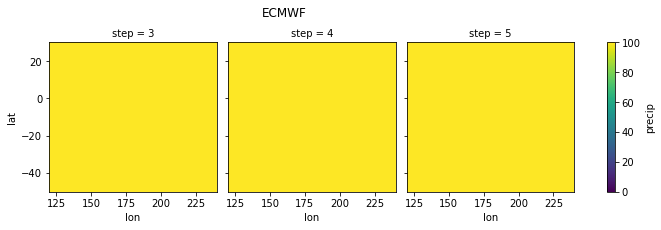

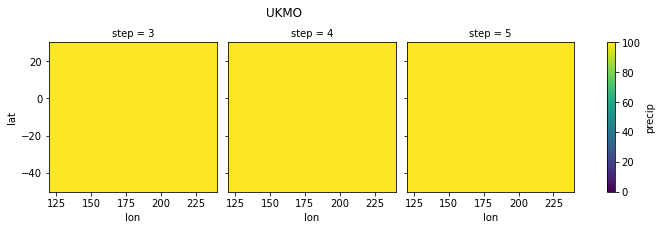

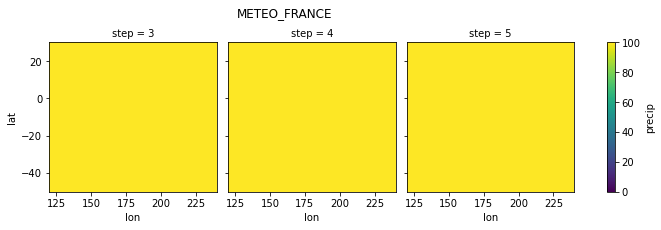

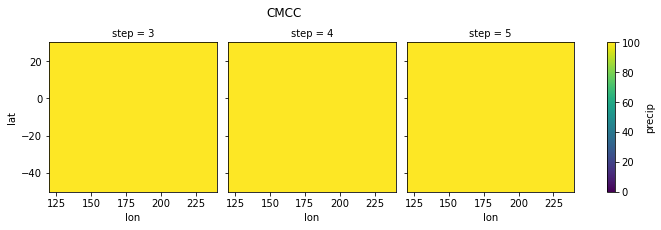

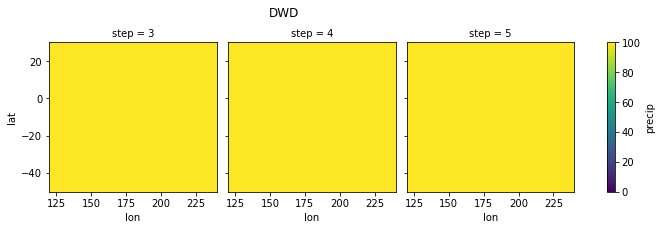

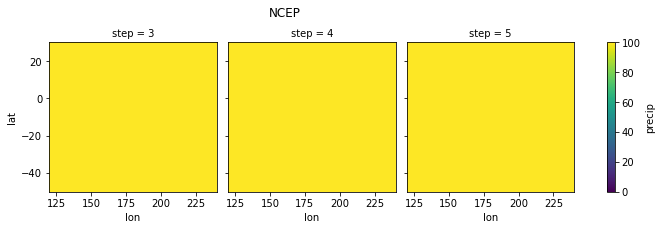

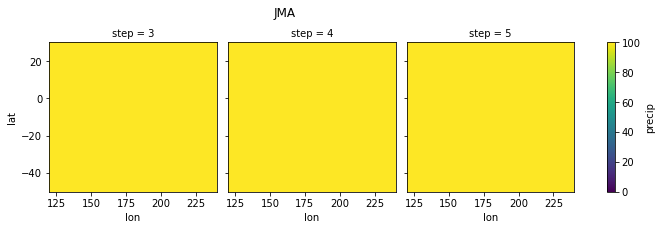

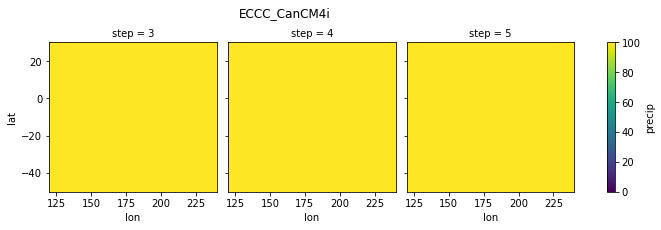

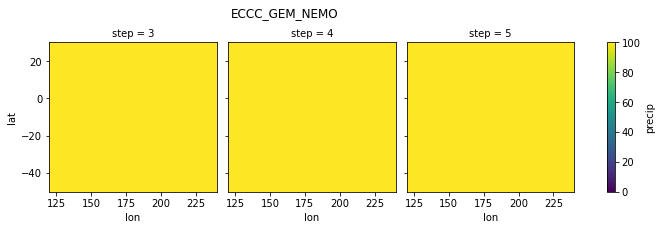

In [25]:
for GCM in list_GCMs:
    fg = probs.sel(GCM=GCM).sum(quantile).squeeze()[varname].plot(col='step', vmin=0);
    fg.fig.suptitle(GCM, x=0.4, horizontalalignment='center',y=1.05)

### calculates the average across the GCM dimension 

In [26]:
probs_mean = probs.mean('GCM')

### saves to disk ?

In [27]:
probs_mean.to_netcdf(f'./C3S_MME_prob_mean_{year}_{month:02d}_{period}.nc')

### because of numerical approximations, this average can **SOMETIMES** sum to slightly over 100 (the errors can accumulate over all the dimensions)

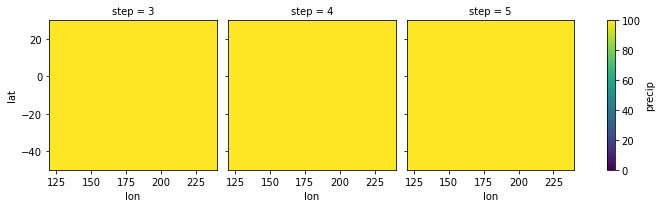

In [28]:
_ = probs_mean.sum(quantile).squeeze()[varname].plot(col='step', vmin=0)

### so we rescale (just in case)

In [29]:
probs_mean = (probs_mean / probs_mean.sum(quantile)) * 100

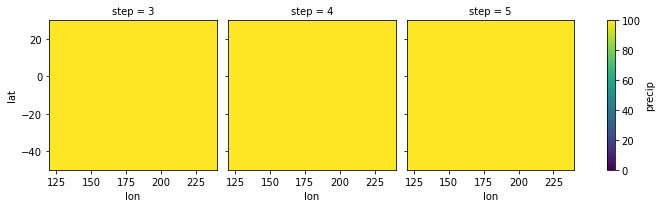

In [30]:
_ = probs_mean.sum(quantile).squeeze()[varname].plot(col='step', vmin=0)

### because the attributes are lost during these operations, we add them back 

In [31]:
probs_mean.attrs = probs.attrs

In [32]:
probs_mean.attrs

{'pct_values': array([0.02, 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])}

#### also adds an attribute that tells the period 

In [33]:
probs_mean.attrs['period'] = period

### Probability for being below a given percentile

#### choose the percentile here 

In [34]:
pmax = 25

### get the percentile bins edges, and select the category (starting at 1) that corresponds to the bin with right edge at `pmax`

In [35]:
print(" | ".join(map(str, probs_mean.attrs['pct_values'].tolist()))) 

0.02 | 0.05 | 0.1 | 0.15 | 0.2 | 0.25 | 0.3 | 0.35 | 0.4 | 0.45 | 0.5 | 0.55 | 0.6 | 0.65 | 0.7 | 0.75 | 0.8 | 0.85 | 0.9 | 0.95


In [36]:
max_cat = np.digitize(pmax/100, probs_mean.attrs['pct_values'])

In [37]:
max_cat

6

In [38]:
probs_mean.percentile

<xarray.DataArray 'percentile' (percentile: 21)>
array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21])
Coordinates:
    month       int64 3
  * percentile  (percentile) int64 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21

### plots the probabilities 

In [39]:
cmap = palettable.scientific.sequential.Bilbao_20.mpl_colormap

### quick plot 

In [40]:
probs_mean.sel({quantile:slice(None, max_cat)})

<xarray.Dataset>
Dimensions:     (time: 1, step: 3, percentile: 6, lon: 726, lat: 486)
Coordinates:
  * time        (time) datetime64[ns] 2022-03-01
  * step        (step) int64 3 4 5
    month       int64 3
  * percentile  (percentile) int64 1 2 3 4 5 6
  * lon         (lon) float64 120.0 120.2 120.3 120.5 ... 239.7 239.8 240.0
  * lat         (lat) float64 -50.0 -49.84 -49.67 -49.51 ... 29.67 29.84 30.0
Data variables:
    precip      (percentile, time, step, lat, lon) float64 dask.array<chunksize=(6, 1, 3, 486, 726), meta=np.ndarray>
Attributes:
    pct_values:  [0.02 0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55...
    period:      seasonal

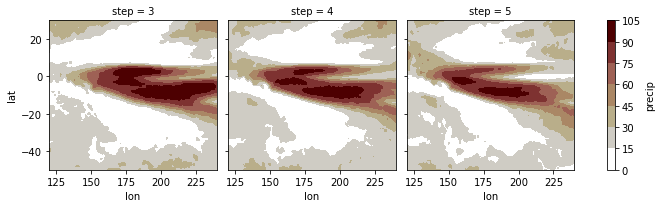

In [41]:
_ = probs_mean.sel({quantile:slice(None, max_cat)}).sum(quantile)[varname].squeeze().plot.contourf(col='step', levels=10, cmap=cmap)

### plot the probabilities for rainfall being below the climatological 25th percentile, for the next 3 months period  

In [42]:
probs_mean

<xarray.Dataset>
Dimensions:     (time: 1, step: 3, percentile: 21, lon: 726, lat: 486)
Coordinates:
  * time        (time) datetime64[ns] 2022-03-01
  * step        (step) int64 3 4 5
    month       int64 3
  * percentile  (percentile) int64 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21
  * lon         (lon) float64 120.0 120.2 120.3 120.5 ... 239.7 239.8 240.0
  * lat         (lat) float64 -50.0 -49.84 -49.67 -49.51 ... 29.67 29.84 30.0
Data variables:
    precip      (percentile, time, step, lat, lon) float64 dask.array<chunksize=(21, 1, 3, 486, 726), meta=np.ndarray>
Attributes:
    pct_values:  [0.02 0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55...
    period:      seasonal

### old version 

In [43]:
# hexes = ['#ffffff', '#f6e8c3', '#dfc27d', '#bf812d', '#8c510a', '#543005']

# cmap = matplotlib.colors.ListedColormap(hexes, name='decile')

### new version 

In [44]:
cmap  = palettable.scientific.sequential.Bilbao_6.mpl_colormap

In [45]:
cmap = plot.cmap_discretize(cmap, 6)

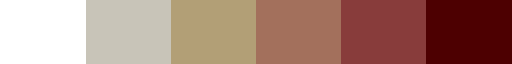

In [46]:
cmap

In [47]:
probs_mean

<xarray.Dataset>
Dimensions:     (time: 1, step: 3, percentile: 21, lon: 726, lat: 486)
Coordinates:
  * time        (time) datetime64[ns] 2022-03-01
  * step        (step) int64 3 4 5
    month       int64 3
  * percentile  (percentile) int64 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21
  * lon         (lon) float64 120.0 120.2 120.3 120.5 ... 239.7 239.8 240.0
  * lat         (lat) float64 -50.0 -49.84 -49.67 -49.51 ... 29.67 29.84 30.0
Data variables:
    precip      (percentile, time, step, lat, lon) float64 dask.array<chunksize=(21, 1, 3, 486, 726), meta=np.ndarray>
Attributes:
    pct_values:  [0.02 0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55...
    period:      seasonal

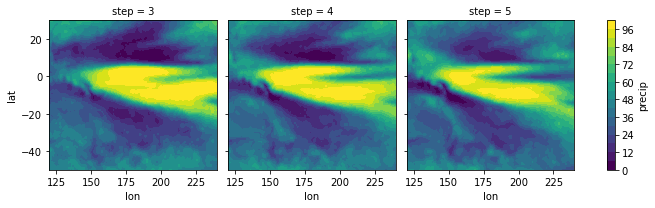

In [48]:
probs_mean.isel(percentile=slice(None, 10)).sum('percentile')['precip'].squeeze().plot.contourf(col='step', levels=20)

In [49]:
fname = f"C3S_MME_{pmax}prob_{period}_lead{lead}_latest.png"

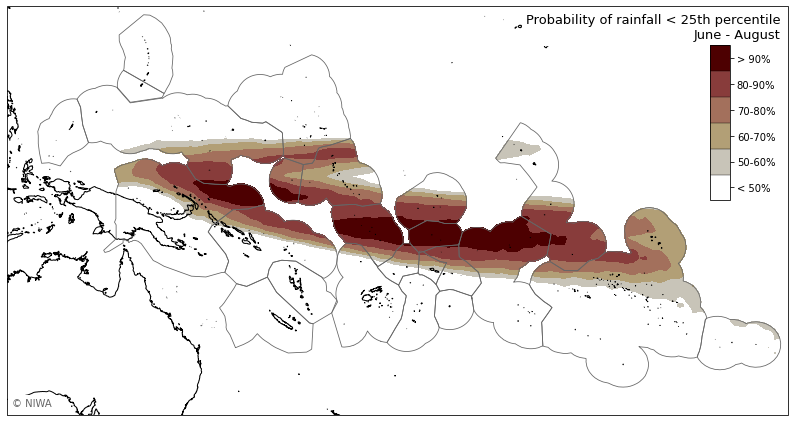

In [50]:
plot.map_MME_forecast(probs_mean, step=step, pct=25, mask=merged_EEZs, geoms=EEZs, fpath=fpath, fname=fname, close=False, domain=domain)

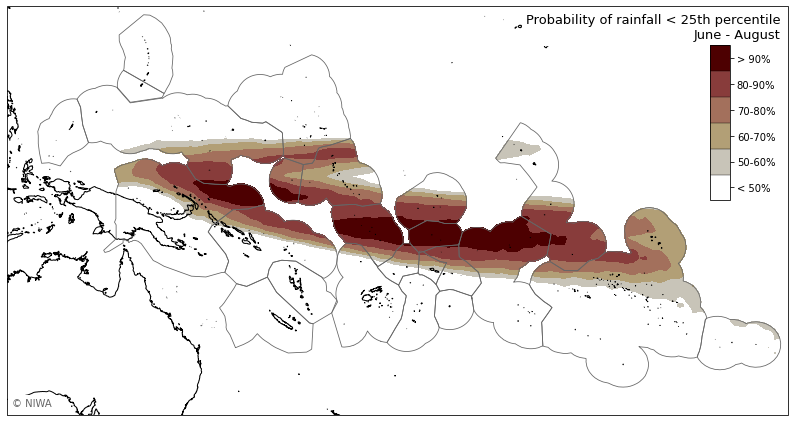

In [51]:
plot.map_MME_forecast(probs_mean, step=step, pct=25, mask=merged_EEZs, geoms=EEZs, fpath=fpath_web, fname=fname, close=False, domain=domain)